## IMPORTS

In [100]:
import yfinance as yf
import json
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, Huber, LogCosh
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
import os
import sys

warnings.filterwarnings('default')

# BEST FOR NOW

In [101]:
# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 90% OF DATA IS TRAINING, 7.5% VALIDATION, 2.5% TEST\
# 30 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND AROON OF 14
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'AroonUp', 'AroonDown']

rsi_period=7
aroon_period=14

training_scaler = 0.9
validation_scaler = 0.075
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 85% OF DATA IS TRAINING, 12,5%% VALIDATION, 2.5% TEST
# 30 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND AROON OF 14
# THIS ONE LOOKS MORE IMPRECISE BUT IS RESULTING IN MORE GAINS
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'AroonUp', 'AroonDown']

rsi_period=7
aroon_period=14

training_scaler = 0.85
validation_scaler = 0.125
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 80% OF DATA IS TRAINING, 17.5% VALIDATION, 2.5% TEST
# 40 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND MACD OF 12-26-9
# THIS ONE LOOKS INCREDIBLY PRECISE. BEST GAINS YET (AMAZING??)
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'MACD_Hist', 'Signal']

# RSI PARAMS
rsi_period=7

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 80% OF DATA IS TRAINING, 17.5% VALIDATION, 2.5% TEST
# 40 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND MACD OF 12-26-9
# Dense layer 7 predictions
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'MACD_Hist', 'Signal']

# RSI PARAMS
rsi_period=7

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

## VARIABLES

In [102]:
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'macd_hist', 'macd_signal', 'aroon_up', 'aroon_down']



## FUNCTIONS

In [103]:
import pandas as pd

def calculate_rsi(df:pd.DataFrame, period=7):
    delta = df['Close'].diff()
    delta = delta.dropna()

    gain, loss = delta.clip(lower=0), delta.clip(upper=0, lower=None)

    # Use Exponential Moving Average for smoother RSI
    ema_up = gain.ewm(alpha=1/period, min_periods=period).mean()
    ema_down = loss.abs().ewm(alpha=1/period, min_periods=period).mean()

    rs = ema_up / ema_down
    print(rs)
    
    df.loc[df.index[-len(rs):], 'rsi'] = 100 - (100 / (1 + rs))

    return df

def calculate_aroon(df:pd.DataFrame, period=25):
    """
    Compute Aroon Up and Aroon Down for a given DataFrame.

    :param df: DataFrame with 'high_price' and 'low_price' columns.
    :param period: Lookback period for Aroon calculation.
    :return: DataFrame with added 'aroon_up' and 'aroon_down' columns.
    """
    # Computar Aroon Up
    df['aroon_up'] = (df['High']
                            .rolling(window=period+1, min_periods=period)
                            .apply(lambda x: (x.argmax() / period), raw=True)*100
    )
    
    # Computar Aroon Up
    df['aroon_down'] = (df['Low']
                                .rolling(window=period+1, min_periods=period)
                                .apply(lambda x: (x.argmin() / period), raw=True)*100
    )
    
    return df

def add_obv(df):
        df["obv"] = np.where(df["Close"] > df["Close"].shift(1), df["Volume"], 
             np.where(df["Close"] < df["Close"].shift(1), -df["Volume"], 0))
        
        df["obv"] = df["obv"].cumsum()
        
        return df

def add_macd(df:pd.DataFrame, fast_period=fast_period, slow_period=slow_period, signal_period=signal_period):
    """
    Adds MACD, Signal line, and MACD Histogram to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the 'Close' price column.
    fast_period (int): Period for the fast EMA (default is 12).
    slow_period (int): Period for the slow EMA (default is 26).
    signal_period (int): Period for the signal line EMA (default is 9).
    
    Returns:
    pd.DataFrame: DataFrame with added MACD, Signal line, and MACD Histogram columns.
    """
    # Calculate the fast and slow EMAs
    df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # Calculate the MACD
    df['macd'] = df['EMA_fast'] - df['EMA_slow']
    
    # Calculate the Signal line
    df['macd_signal'] = df['macd'].ewm(span=signal_period, adjust=False).mean()
    
    # Calculate the MACD Histogram
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Drop the intermediate EMA columns
    df.drop(columns=['EMA_fast', 'EMA_slow'], inplace=True)
    
    return df


## OBTAINING DATA
1) Tickers
2) Data treatment
3) Sequence creation
4) Data splitting

In [104]:
df_scaled_list = []

# RSI PARAMS
rsi_period=14

#AROON PARAMS
aroon_period = 14

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 128*2


# data = ticker.history(period='max')

# data = data[data.index>=start_date]
stock_data = pd.read_csv('values_msft.csv', sep=',', index_col=0)
# data.drop(columns=['id', 'ticker_id', 'aroon_down', 'aroon_up', 'macd', 'macd_hist', 'macd_signal', 'rsi', 'created_at', 'updated_at', 'obv'], inplace=True)
stock_data.sort_index(ascending=True, inplace=True)
stock_data.set_index('value_at', inplace=True)
stock_data.drop(labels=['created_at', 'updated_at'], axis=1, inplace=True)
stock_data['target'] = stock_data['closing_price']
stock_data.dropna(inplace=True)
print(stock_data.head(5))

# stock_data = pd.read_csv('MSFT_30.csv', sep=';', index_col=0)
# stock_data.set_index('Date', inplace=True)
# stock_data.sort_index(ascending=True, inplace=True)
# stock_data['target'] = stock_data['Close']
# stock_data.dropna(inplace=True)



            ticker_id  opening_price  closing_price  high_price  low_price  \
value_at                                                                     
2025-02-07          2         416.48         409.75      418.65     408.10   
2025-02-10          2         413.63         412.22      415.47     410.92   
2025-02-11          2         409.64         411.44      412.49     409.30   
2025-02-12          2         407.27         409.04      410.75     404.38   
2025-02-13          2         407.24         410.54      411.00     406.36   

            volume    rsi  aroon_up  aroon_down    macd  macd_hist  \
value_at                                                             
2025-02-07  106815  38.96     42.86      100.00 -4.6808    -2.4441   
2025-02-10   69478  41.05     35.71       92.86 -4.9776    -2.1927   
2025-02-11   53655  40.58     28.57       85.71 -5.2157    -1.9446   
2025-02-12   71178  39.09     21.43      100.00 -5.5342    -1.8105   
2025-02-13   76107  40.56     14.

In [105]:
import utils.modelmethods as mm 
# Extrer datos diccionario
ticker_code = 'MSFT'

# Variables generadoras de configuracion base de modelo.
batch_size = 32
epochs = 100
lookback = 3
predict_days = 1
patience = 10
# Variables generadoras de capas
initial_complexity = 128
is_bidirectional = True
max_layers = 3
int_activation = 'relu'
out_activation = 'linear'
dropout_rate = 0.2


# Variables de split de datos
train_scaler = 0.8
validation_scaler = 0.175


#############################################################
######### A partir de aqui comienzan las iteraciones ########
#############################################################

# Features a utilizar. Se ha definido un minimo de 3 features y un maximo de 4.
# El valor de macd es redundante
variable_columns = ['opening_price', 'obv', ('aroon_up', 'aroon_down'), 'macd_hist', 'rsi']
base_columns = ['closing_price', 'target'] # El target se debe eliminar de X mas adelante

combination_columns = mm.generate_features(variable_columns)


complexities=[initial_complexity]
for _ in range(2):
    complexities.append(complexities[-1]//2)

count=1

print(combination_columns)

[['opening_price', 'obv'], ['opening_price', 'aroon_up', 'aroon_down'], ['opening_price', 'macd_hist'], ['opening_price', 'rsi'], ['obv', 'aroon_up', 'aroon_down'], ['obv', 'macd_hist'], ['obv', 'rsi'], ['aroon_up', 'aroon_down', 'macd_hist'], ['aroon_up', 'aroon_down', 'rsi'], ['macd_hist', 'rsi']]


Dataframe escalado: [0.29259875 0.29259875 0.31372801 0.5562838 ]
Secuencias creadas: [[0.26102518 0.35032747 0.5147463 ]
 [0.29259875 0.31372801 0.5562838 ]
 [0.28262815 0.26248876 0.5242061 ]]
Datos listos: [[0.26102518 0.35032747 0.5147463 ]
 [0.29259875 0.31372801 0.5562838 ]
 [0.28262815 0.26248876 0.5242061 ]]
------
[[[0.26102518 0.35032747 0.5147463 ]
  [0.29259875 0.31372801 0.5562838 ]
  [0.28262815 0.26248876 0.5242061 ]]

 [[0.29259875 0.31372801 0.5562838 ]
  [0.28262815 0.26248876 0.5242061 ]
  [0.25194938 0.23205342 0.48165225]]

 [[0.28262815 0.26248876 0.5242061 ]
  [0.25194938 0.23205342 0.48165225]
  [0.27112361 0.23166816 0.52715291]]]
[[0.25194938]
 [0.27112361]
 [0.32890196]]
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 163655.3594 - mape: 163655.3594 - mse: 0.2381 - val_loss: 114.9068 - val_mape: 114.9068 - val_mse: 0.0625
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 46659.3398 - mape: 46659.3398 - mse: 0.2722 - val_loss: 136.5572 - val_

Model: "model_cp_1.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_21                │ (None, 3, 512)         │       532,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 512)            │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,323,717 (24.12 MB)

 Trainable params: 2,107,905 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,215,812 (16.08 MB)

None


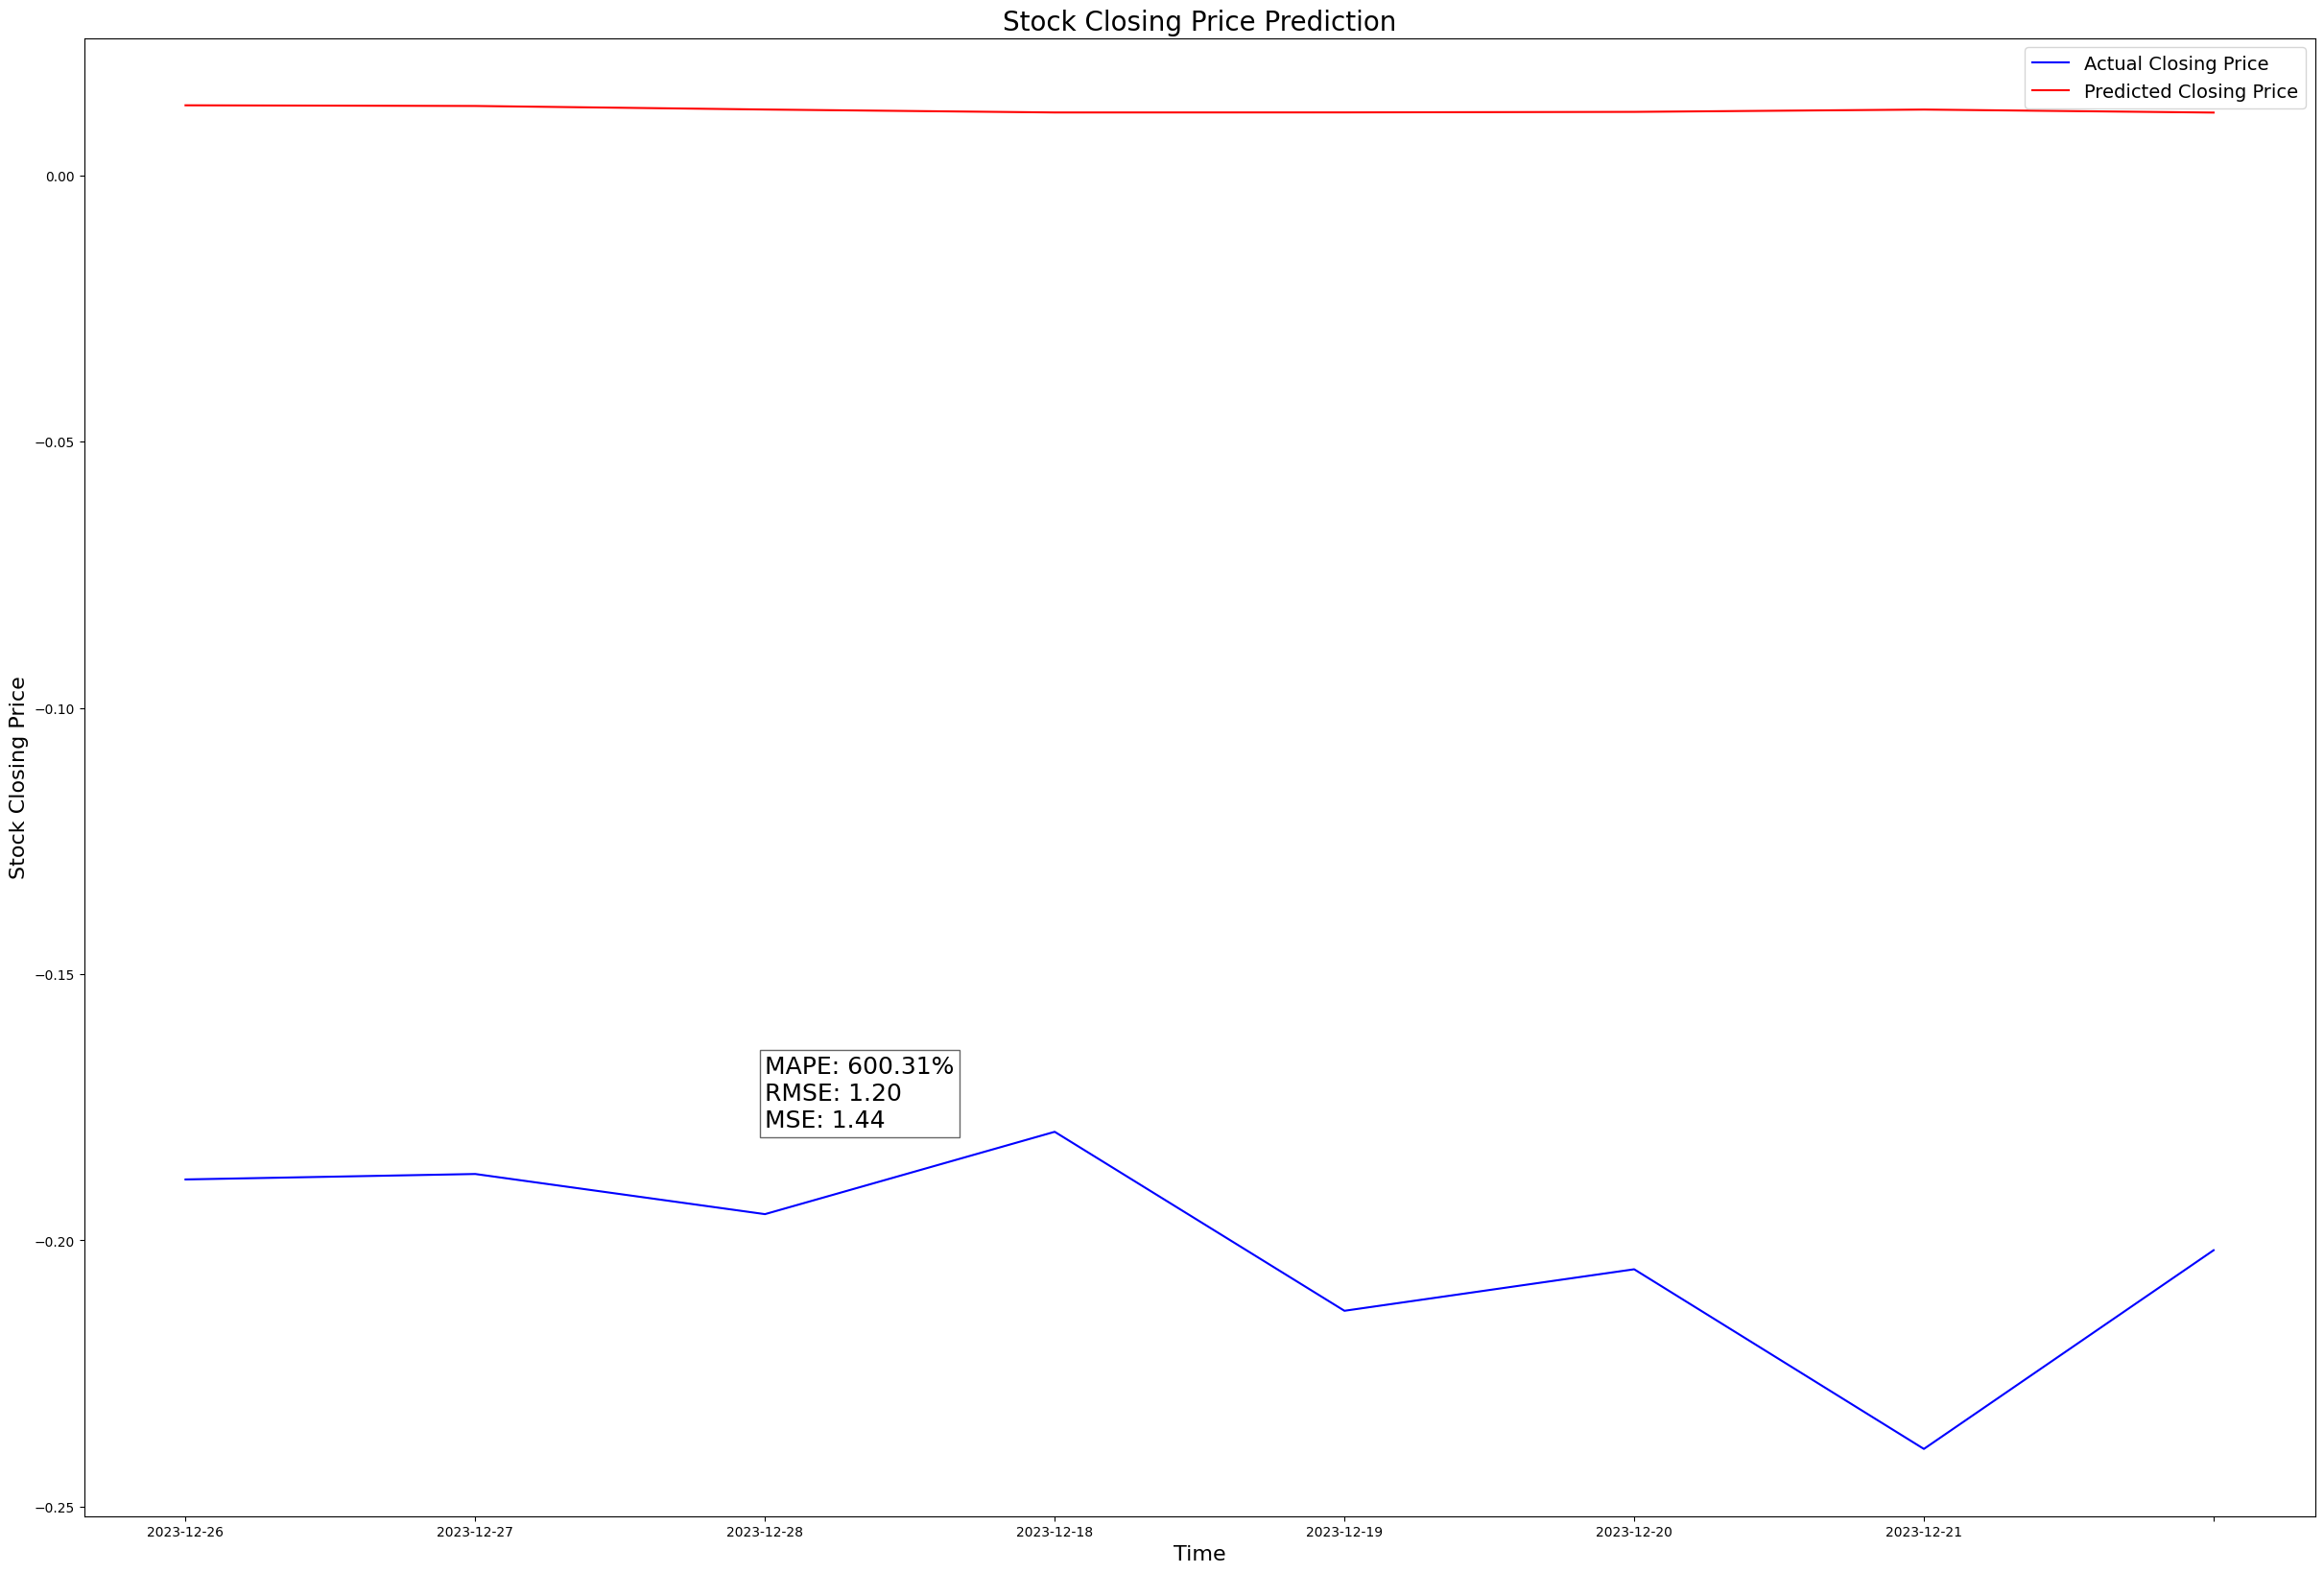

In [ ]:
import keras 
import warnings

warnings.filterwarnings('ignore')

for combination in combination_columns:                
    # Obtenemos las features de la iteracion
    features = base_columns+combination            

    df = stock_data[features].copy()  # Obtenemos el df con las features que queremos
    
    train_split = int(train_scaler * len(df))  # Training set size
    val_split = int(validation_scaler * len(df))  # Validation set size
    
    scaler = MinMaxScaler(feature_range=(0, 1))

    df_scaled = mm.scale_dataframe(scaler, train_split, val_split, df, features)
    
    print(f'Dataframe escalado: {df_scaled.iloc[1].values}')
    
    X, y = mm.create_sequences(df_scaled, lookback, predict_days)
    
    print(f'Secuencias creadas: {X[0]}')
    
    # Obtenemos los splits
    X_train, X_val, X_test, y_train, y_val, y_test = mm.obtain_split(X, y, train_scaler, validation_scaler)
    
    print(f'Datos listos: {X_train[0]}')
    
    for n_layers in range(1, len(complexities)+1):
        # to_use = complexities[:n_layers]
        
        # print(f'Generando modelo {count}, complejidades {to_use} y features {features} para el ticker {ticker_code.upper()}')
        
        # model = keras.Sequential()
        # model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2]))) # Indicar shape con las features
        # for idx, units in enumerate(to_use):
        #     if is_bidirectional:
        #         print(f'Incluyendo capa BiLSTM {int_activation} de complejidad {units}')
        #         if idx==n_layers-1:
        #             model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=units, activation=int_activation, return_sequences=False)))
        #         else:
        #             model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=units, activation=int_activation, return_sequences=True)))
        #     else:
        #         print(f'Incluyendo capa LSTM {int_activation} de complejidad {units}')
        #         if idx==n_layers-1:
        #             model.add(keras.layers.LSTM(units, activation=int_activation, return_sequences=False))
        #         else:
        #             model.add(keras.layers.LSTM(units, activation=int_activation, return_sequences=True))
        
        # if dropout_rate!=0:
        #     print(f'Incluyendo capa Dropout con proporcion {dropout_rate}')
        #     model.add(keras.layers.Dropout(dropout_rate))
            
        # print(f'Incluyendo capa de salida {out_activation} con {predict_days} unidades')
        # model.add(keras.layers.Dense(units=predict_days, activation=out_activation))
        
        
        # print(f'Compilando modelo con optimizador adam, funcion de perdida mape')
        # model.compile(optimizer='adam', loss='mape', metrics=['mse', 'mae'])
        
        # this_model = f"model_{ticker_code.lower()}_{'_'.join(str(feature) for feature in features)}_{n_layers}.keras"
        
        # print(f'Creando directorio: {this_model}')

        # cp = keras.callbacks.ModelCheckpoint(this_model, save_best_only=True, save_weights_only=False)
        # model.compile(optimizer='adam', loss='mape', metrics=['mse', 'mape'])
        # early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        
        # # Hacer fit del modelo actual
        # history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[cp,early_stopping])
        
        ################################################################################
        this_model = f'model_cp_1.keras'
        print('------')
        print(X_train[:3])
        print(y_train[:3])
        
        model = Sequential(name=this_model)
        model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
        # for i in range(1,3):
        model.add(Bidirectional(LSTM(units=lstm_complexity, activation='relu', return_sequences=True)))
        model.add(Bidirectional(LSTM(units=lstm_complexity, activation='relu')))
        # model.add(Bidirectional(LSTM(units=32)))
        # model.add(Bidirectional(LSTM(units=lstm_complexity)))
        # model.add(Dropout(0.3))
        # model.add(LSTM(units=50, return_sequences=False))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='linear'))
        
        
        if os.path.exists(this_model):
            os.remove(this_model)
            
        cp = ModelCheckpoint(this_model, save_best_only=True)
        model.compile(optimizer='adam', loss='mape', metrics=['mse', 'mape'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batches, callbacks=[cp,early_stopping])
        
        ##################################################################################
        
        
        # # # Load the best model
        model.load_weights(this_model)
        # Evaluate the model on the test set
        test_loss = model.evaluate(X_test, y_test)
        print(test_loss)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        
        
        break
    
    break


print(model.summary())

# Compute Metrics
# mape = mean_absolute_percentage_error(y_test, y_pred) * 100
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# Plot the results
plt.figure(figsize=(30, 20))
plt.plot(y_test, color='blue', label='Actual Closing Price')
plt.plot(y_pred, color='red', label='Predicted Closing Price')

# Add Title and Labels
plt.gca().set_xticklabels(stock_data[train_split+val_split:].index)
plt.title('Stock Closing Price Prediction', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Closing Price', fontsize=16)
plt.legend(fontsize=14)

# Display metrics on the plot
# metrics_text = f"MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}\nMSE: {mse:.2f}"
# plt.text(2, max(y_test) * 0.995, metrics_text, fontsize=18, color='black', 
#         bbox=dict(facecolor='white', alpha=0.6))

# Show plot
plt.show()

    
        

## OLD CODE NOW

In [107]:
def create_sequences(data, lookback=60, forecast_horizon=2):
    sequences = []
    targets = []
    
    for i in range(lookback, len(data) - forecast_horizon + 1):  # Prevent index out of range
        sequences.append(data.iloc[i - lookback:i].values)  # Input sequence of past 'lookback' days
        targets.append(data.iloc[i:i + forecast_horizon]['target'].values)  # Predict next 2 days
    
    return np.array(sequences), np.array(targets)  # Targets will now have shape (samples, 2)


In [108]:
import utils.modelmethods as mm

X, y = create_sequences(df, 3, 1)

print(df.shape)
print(training_scaler)
print(validation_scaler)

X_train, X_val, X_test, y_train, y_val, y_test = mm.obtain_split(X, y, training_scaler, validation_scaler)

print(f'\nX length: {len(X)}')
print(f'Train: {len(X_train)}')
print(f'Val: {len(X_val)}')
print(f'Test: {len(X_test)}')
print(f'Total size: {len(X_train)+len(X_val)+len(X_test)}')

print('\nX Train:')
print(X_train[:3])

print('\ny Train:')
print(y_train[:3])

print(X_train.shape[1])



(290, 4)
0.8
0.175

X length: 287
Train: 228
Val: 49
Test: 8
Total size: 285

X Train:
[[[4.09750e+02 4.09750e+02 4.16480e+02 6.68874e+05]
  [4.12220e+02 4.12220e+02 4.13630e+02 7.38352e+05]
  [4.11440e+02 4.11440e+02 4.09640e+02 6.84697e+05]]

 [[4.12220e+02 4.12220e+02 4.13630e+02 7.38352e+05]
  [4.11440e+02 4.11440e+02 4.09640e+02 6.84697e+05]
  [4.09040e+02 4.09040e+02 4.07270e+02 6.13519e+05]]

 [[4.11440e+02 4.11440e+02 4.09640e+02 6.84697e+05]
  [4.09040e+02 4.09040e+02 4.07270e+02 6.13519e+05]
  [4.10540e+02 4.10540e+02 4.07240e+02 6.89626e+05]]]

y Train:
[[409.04]
 [410.54]
 [415.06]]
3


In [109]:
from utils.plotter import LSTMPlotter

plotter = LSTMPlotter(rows=3, cols=1)

None

TypeError: LSTMPlotter.__init__() got an unexpected keyword argument 'rows'

: 

## GENERATE MODEL

In [ ]:

for i in range(1,3):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
    # for i in range(1,3):
    model.add(Bidirectional(LSTM(units=lstm_complexity, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(units=lstm_complexity, activation='relu')))
    # model.add(Bidirectional(LSTM(units=32)))
    # model.add(Bidirectional(LSTM(units=lstm_complexity)))
    model.add(Dropout(0.3))
    # model.add(LSTM(units=50, return_sequences=False))
    # model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='linear'))

    # print(model.summary())

    cp_path = f'model_cp_{i}.keras'
    if os.path.exists(cp_path):
        os.remove(cp_path)
        
    cp = ModelCheckpoint(cp_path, save_best_only=True)
    model.compile(optimizer='adam', loss='mape', metrics=['mse', 'mape'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batches, callbacks=[cp,early_stopping])

    # # Load the best model
    # model.load_weights(cp_path)
    # # Evaluate the model on the test set
    # test_loss = model.evaluate(X_test, y_test)
    # print(test_loss)
    
    # # Make predictions on the test set
    # y_pred = model.predict(X_test)
        
    # plotter.add_plot(y_test, y_pred, cp_path)
    
    # None

Epoch 1/100


c:\Users\nacho\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


KeyboardInterrupt: 

: 

In [12]:
plotter.show()

<Figure size 640x480 with 0 Axes>

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


# Compute Metrics
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Plot the results
plt.figure(figsize=(30, 20))
plt.plot(y_test, color='blue', label='Actual Closing Price')
plt.plot(y_pred, color='red', label='Predicted Closing Price')

# Add Title and Labels
plt.gca().set_xticklabels(df[train_split+val_split:].index)
plt.title('Stock Closing Price Prediction', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Closing Price', fontsize=16)
plt.legend(fontsize=14)

# Display metrics on the plot
metrics_text = f"MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}\nMSE: {mse:.2f}"
plt.text(2, max(y_test) * 0.995, metrics_text, fontsize=18, color='black', 
         bbox=dict(facecolor='white', alpha=0.6))

# Show plot
plt.show()


NameError: name 'y_pred' is not defined

## SIGNALING

In [275]:
test=[1,2,3]
print(type(y_test))

def duplicate_features(data, n_features=len(features)):
    return np.tile(data.reshape(-1, 1), n_features)

# Duplicate y_test and y_pred to have 4 identical columns
y_test_duplicated = duplicate_features(y_test)
y_pred_duplicated = duplicate_features(y_pred)

# Perform inverse transform
y_test_original_duplicated = scaler.inverse_transform(y_test_duplicated)
y_pred_original_duplicated = scaler.inverse_transform(y_pred_duplicated)

# Extract the first column
y_test_original = y_test_original_duplicated[:, 0]
y_pred_original = y_pred_original_duplicated[:, 0]


# Create DataFrame
# y_pred = y_pred.flatten()
n_df = pd.DataFrame({
    'actual': y_test_original,
    'predicted': y_pred_original
})

# Generate trading signals
n_df['buy_signal'] = n_df['predicted'].diff().shift(-2) > 0
n_df['sell_signal'] = n_df['predicted'].diff().shift(-2) < 0

# # Initialize variables for tracking trades
# position = 0  # 1 for holding, 0 for not holding
# buy_price = 0
# total_profit = 0
# trades = []


# # Simulate trades
# for i in range(len(df)):
#     if df['buy_signal'][i] and position == 0:
#         # Buy
#         position = 1
#         buy_price = df['actual'][i]
#     elif df['sell_signal'][i] and position == 1:
#         # Sell
#         position = 0
#         sell_price = df['actual'][i]
#         profit = sell_price - buy_price
#         total_profit += profit
#         trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'profit': profit})

# Initialize variables for tracking trades
position = 0  # 1 for holding, 0 for not holding
buy_price = 0
total_profit = 0
trades = []

buys = []

# Simulate trades
for i in range(len(df)):
    if n_df['buy_signal'][i]:
        # Buy
        position = 1
        buy_price = n_df['actual'][i]
        buys.append(buy_price)
    elif n_df['sell_signal'][i] and position == 1:
        # Sell
        position = 0
        sell_price = n_df['actual'][i]
        profit = sum(sell_price - x for x in buys)
        total_profit += profit
        trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'profit': profit})
        buys = []

# Identify buy and sell indices
buy_indices = n_df.index[n_df['buy_signal']].tolist()
sell_indices = n_df.index[n_df['sell_signal']].tolist()

# Convert trades to DataFrame for analysis
trades_df = pd.DataFrame(trades)

# Plot the results
plt.figure(figsize=(30, 20))
plt.plot(n_df['actual'], color='blue', label='Actual Closing Price')
plt.plot(n_df['predicted'], color='red', label='Predicted Closing Price')

# Plot buy and sell signals
plt.scatter(buy_indices, n_df['actual'][buy_indices], color='green', marker='^', s=100, label='Buy Signal')
plt.scatter(sell_indices, n_df['actual'][sell_indices], color='orange', marker='v', s=100, label='Sell Signal')

plt.title('Stock Closing Price Prediction with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Stock Closing Price')
plt.legend()

plt.locator_params(axis='x', nbins=2)

plt.show()

# Print performance metrics
print(f"Total Profit: {total_profit:.2f}")
print(f"Number of Trades: {len(trades_df)}")
print(f"Average Profit per Trade: {trades_df['profit'].mean():.2f}")


<class 'numpy.ndarray'>


KeyError: 2